In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import shutil
import random
import torch
import glob
import numpy as np
from torch.utils.data import Subset
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torchvision.datasets import ImageFolder
from torchvision.models import vgg19, VGG19_Weights
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader
from PIL import Image
from torch.utils.data import SubsetRandomSampler

## 📊 데이터셋 통계 계산 (Mean & Std)

전체 이미지에서 평균(mean)과 표준편차(std)를 계산하여 정규화에 사용할 통계값을 구합니다.

- RGB 채널별로 픽셀 합계와 제곱 합계를 누적
- 전체 픽셀 수로 나누어 평균과 표준편차 도출
- 이후 데이터 전처리(normalization)에 활용

In [3]:
import cv2
from tqdm import tqdm

image_dir = "/content/drive/MyDrive/개인_팀_프로젝트/VGG19_모델_구현, 전이학습/data/santa/train"

pixel_sum = np.zeros(3)
pixel_sum_sq = np.zeros(3)
pixel_count = 0

for root, _, files in os.walk(image_dir):
    for file in tqdm(files):
        if file.endswith(('.jpg', '.png', '.jpeg')):
            img_path = os.path.join(root, file)

            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = img.astype(np.float32) / 255.0  # 정규화 전 단계

            pixel_sum += img.sum(axis=(0,1))
            pixel_sum_sq += (img ** 2).sum(axis=(0,1))
            pixel_count += img.shape[0] * img.shape[1]

mean = pixel_sum / pixel_count
std = np.sqrt(pixel_sum_sq / pixel_count - mean ** 2)

print(f"평균: {mean}")
print(f"표준편차: {std}")

0it [00:00, ?it/s]
100%|██████████| 446/446 [00:32<00:00, 13.61it/s]

평균: [0.5429284  0.43834987 0.41621647]
표준편차: [0.28189653 0.32122606 0.3198775 ]


## 🔄 데이터 전처리 파이프라인 설정

학습/검증 데이터에 적용할 **Transform** 정의

**Train**: 224×224 리사이즈 → 랜덤 좌우 반전(증강) → 텐서 변환 → 정규화  
**Validation**: 224×224 리사이즈 → 텐서 변환 → 정규화

- VGG19 입력 크기(224×224)에 맞게 조정
- 학습 데이터만 증강 기법 적용으로 과적합 방지

In [4]:
# transform은 데이터들을 0~255 값들을 0~1로 정규화 시킨다.
transform_train = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(), # 데이터 증강
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])

transform_val = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])

## 📁 데이터셋 로딩

`ImageFolder`로 train/validation 데이터셋 생성

- 폴더 구조 기반 자동 레이블링
- 각 데이터셋에 정의된 transform 적용

In [5]:
image_datasets = {
    'train': datasets.ImageFolder('/content/drive/MyDrive/개인_팀_프로젝트/VGG19_모델_구현, 전이학습/data/santa/train', transform=transform_train),
    'validation': datasets.ImageFolder('/content/drive/MyDrive/개인_팀_프로젝트/VGG19_모델_구현, 전이학습/data/santa/val', transform=transform_val),
}

## 🔃 DataLoader 생성

배치 단위로 데이터를 공급하는 DataLoader 설정

- **Batch size**: 32
- **Train**: 셔플 활성화 (매 에포크마다 순서 변경)
- **Validation**: 셔플 비활성화 (일관된 평가)

In [6]:
BATCH_SIZE = 32

train_loader = DataLoader(dataset=image_datasets['train'], batch_size = BATCH_SIZE, shuffle = True)
val_loader = DataLoader(dataset=image_datasets['validation'], batch_size = BATCH_SIZE, shuffle = False)

In [7]:
train_features, train_labels = next(iter(train_loader))
print(train_labels.shape, train_labels.dtype)

torch.Size([32]) torch.int64


## **✅ 이미지 확인**

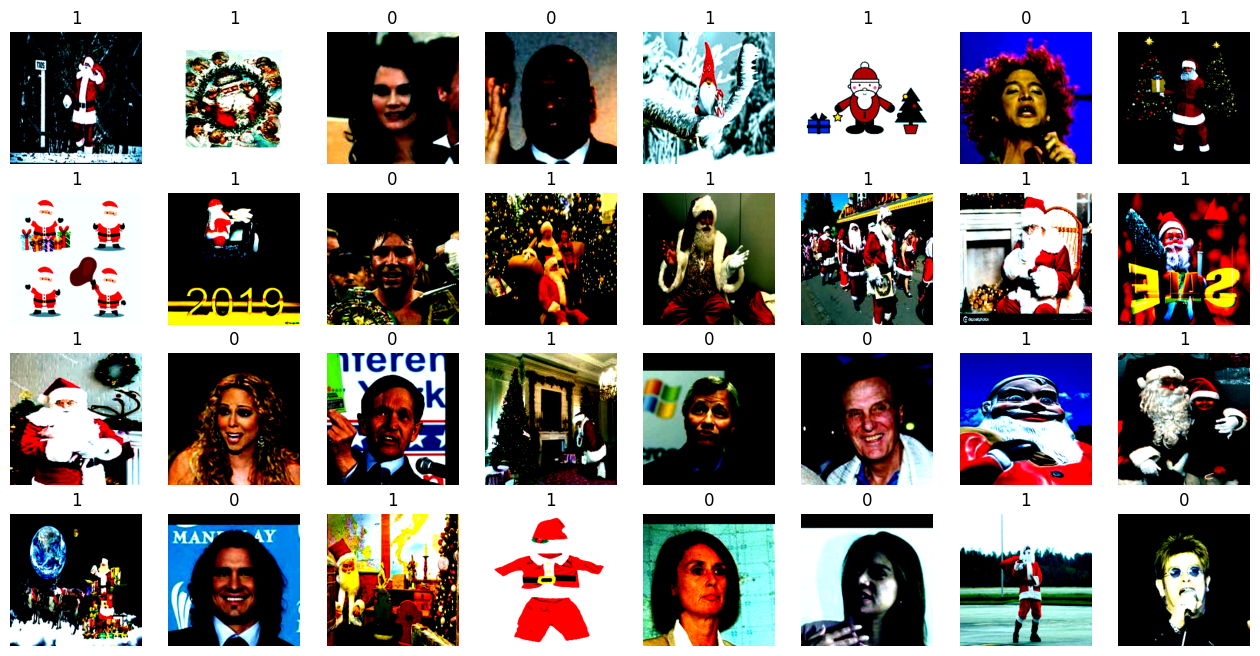

In [8]:
imgs, labels = next(iter(train_loader))

fig, axes = plt.subplots(4, 8, figsize=(16, 8))

for ax, img, label in zip(axes.flatten(), imgs, labels):
    ax.imshow(img.permute(1, 2, 0)) # (3, 224, 224) -> (224, 224, 3)
    ax.set_title(label.item())
    ax.axis('off')

## 🏗️ VGG19 모델 구현 (논문 기반)

VGG19 아키텍처를 **논문 그대로** 구현

**Features (Conv Blocks)**:
- 5개 블록, 16개 Conv 레이어 (3×3 커널)
- 각 블록마다 MaxPooling으로 feature map 크기 축소
- 채널 수: 64 → 128 → 256 → 512 → 512

**Classifier (FC Layers)**:
- FC1, FC2: 4096 units + ReLU + Dropout(0.5)
- FC3: num_classes (출력층)

최종 출력: 512×7×7 → Flatten → 분류

In [9]:
from torch.nn.modules.activation import ReLU
from torch.nn.modules.conv import Conv2d
# VGG19 모델 직접 구현
class VGG19(nn.Module):
    def __init__(self, num_classes=2):
        super(VGG19, self).__init__()
        self.features = nn.Sequential(
            # 3, 224, 224
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, stride=1, padding=1),  # Conv1
            nn.ReLU(inplace=True),
            # 64, 224, 224
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1),  # Conv2
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2), # max 1 64, 112, 112

            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1), # Conv3
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1), # Conv4
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2), # max 2 128, 56, 56

            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1), # Conv5
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1), # Conv6
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1), # Conv7
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1), # Conv8
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2), # max 3 256, 28, 28

            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, stride=1, padding=1), # Conv9
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1), # Conv10
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1), # Conv11
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1), # Conv12
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2), # max 4 512, 14, 14

            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1), # Conv13
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1), # Conv14
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1), # Conv15
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1), # Conv16
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2) # max 5 512, 7, 7
        )

        self.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),  # FC1 (Flatten 크기 조정)
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),

            nn.Linear(4096, 4096),        # FC2
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),

            nn.Linear(4096, num_classes), # FC3
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)  # Flatten
        x = self.classifier(x)
        return x

# ✅**손실함수 설정 / Cuda 설정**

In [10]:
criterion = nn.CrossEntropyLoss()

In [11]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
DEVICE

device(type='cuda')

## 🎓 학습 함수 정의

모델 학습 및 검증을 수행하는 `train_model` 함수

**주요 기능**:
- Optimizer 선택 (SGD/Adam)
- 에포크마다 학습 손실(train loss) 계산
- 검증 손실(val loss) 및 정확도(accuracy) 계산
- 학습 과정 추적을 위한 손실/정확도 기록 반환

**학습 흐름**: Forward → Loss 계산 → Backward → 파라미터 업데이트

In [12]:
def train_model(optimizer_name, model, train_loader, val_loader, criterion, num_epochs=15):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    # optimizer 설정
    if optimizer_name == 'SGD':
        optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
    elif optimizer_name == 'Adam':
        optimizer = optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999))
    else:
        raise ValueError(f"Unsupported optimizer: {optimizer_name}")

    # 학습/검증 손실과 검증 정확도를 저장할 리스트
    train_losses = []
    val_losses = []
    val_accuracies = []

    for epoch in range(num_epochs):
        model.train()  # 모델을 학습 모드로 설정
        running_loss = 0.0

        for i, data in enumerate(train_loader):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        # 매 에포크마다 평균 학습 손실 계산
        train_loss = running_loss / len(train_loader)
        train_losses.append(train_loss)

        # 검증 손실 계산
        val_loss = 0.0
        model.eval()  # 모델을 평가 모드로 설정
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                loss = criterion(outputs, labels)
                val_loss += loss.item()

        val_loss /= len(val_loader)
        val_losses.append(val_loss)

        val_accuracy = 100 * correct / total
        val_accuracies.append(val_accuracy)

        print(f'[{optimizer_name}] Epoch {epoch + 1}, Train Loss: {train_loss:.6f}, Val Loss: {val_loss:.6f}, Validation Accuracy: {val_accuracy:.2f}%', flush=True)

    return train_losses, val_losses, val_accuracies

## ❌ 직접 구현 모델 학습 시도 (실패)

논문 기반 VGG19 모델을 **처음부터(from scratch)** 학습

**결과**: Loss = NaN, Accuracy ≈ 50% (랜덤 수준)

**실패 원인**:
- 데이터 부족 (~900장) → VGG19의 1억+ 파라미터 학습 불가
- 사전 학습 없이 무작위 초기화된 가중치로는 수렴 실패

➡️ **전이학습(Transfer Learning)** 필요성 확인

In [13]:
model = VGG19(num_classes=2)

In [20]:
origin_model_train_losses_Adam, origin_model_val_losses_Adam, origin_model_val_accuracies_Adam = train_model('Adam', model, train_loader, val_loader, criterion)

[Adam] Epoch 1, Train Loss: nan, Val Loss: nan, Validation Accuracy: 50.19%
[Adam] Epoch 2, Train Loss: nan, Val Loss: nan, Validation Accuracy: 50.19%
[Adam] Epoch 3, Train Loss: nan, Val Loss: nan, Validation Accuracy: 50.19%
[Adam] Epoch 4, Train Loss: nan, Val Loss: nan, Validation Accuracy: 50.19%
[Adam] Epoch 5, Train Loss: nan, Val Loss: nan, Validation Accuracy: 50.19%
[Adam] Epoch 6, Train Loss: nan, Val Loss: nan, Validation Accuracy: 50.19%
[Adam] Epoch 7, Train Loss: nan, Val Loss: nan, Validation Accuracy: 50.19%
[Adam] Epoch 8, Train Loss: nan, Val Loss: nan, Validation Accuracy: 50.19%
[Adam] Epoch 9, Train Loss: nan, Val Loss: nan, Validation Accuracy: 50.19%
[Adam] Epoch 10, Train Loss: nan, Val Loss: nan, Validation Accuracy: 50.19%
[Adam] Epoch 11, Train Loss: nan, Val Loss: nan, Validation Accuracy: 50.19%
[Adam] Epoch 12, Train Loss: nan, Val Loss: nan, Validation Accuracy: 50.19%
[Adam] Epoch 13, Train Loss: nan, Val Loss: nan, Validation Accuracy: 50.19%
[Adam] E

## 🔍 데이터 검증 (디버깅)

학습 실패 원인 파악을 위한 데이터 검증

- 클래스별 폴더-인덱스 매핑 확인
- Train 데이터의 레이블 분포 체크
- 데이터 불균형 또는 로딩 오류 여부 확인

➡️ 데이터 문제가 아닌 **모델/학습 설정** 문제임을 확인

In [15]:
# 1. 클래스 인덱스 매핑 확인
print("Class Mapping (Folder to Index):", image_datasets['train'].class_to_idx)

# 2. 실제 배치 데이터의 레이블 분포 확인
from collections import Counter

train_counts = Counter()
for _, labels in train_loader:
    train_counts.update(labels.tolist())

print("Train Label Distribution:", train_counts)
# 예: Counter({0: 160, 1: 160}) 처럼 균형이 맞아야 합니다.
# 만약 한쪽이 0개라면 데이터 로더 설정이나 경로 문제입니다.

Class Mapping (Folder to Index): {'normal': 0, 'santa': 1}
Train Label Distribution: Counter({0: 449, 1: 446})


## ✅ 전이학습 적용 (Transfer Learning)

ImageNet으로 사전 학습된 VGG19 모델 활용

**전략**:
- **Features (Conv layers)**: 가중치 고정(Freeze) → 특징 추출기로만 사용
- **Classifier (FC layers)**: 2개 클래스에 맞게 재정의 → 학습 대상

**결과**:
- Epoch 1부터 91.76% 달성
- 최종 검증 정확도 **~97%** (전이학습의 효과 입증)

➡️ 적은 데이터로도 높은 성능 확보 성공! 🎯

In [24]:
import torch.nn as nn
from torchvision.models import vgg19, VGG19_Weights

# 1. ImageNet 데이터로 미리 학습된 VGG19 모델 불러오기
weights = VGG19_Weights.IMAGENET1K_V1
model = vgg19(weights=weights)

# 2. 특징 추출기(Features) 부분의 가중치 고정 (Freeze)
# 데이터가 적으므로 앞단은 학습시키지 않고 그대로 사용합니다.
for param in model.features.parameters():
    param.requires_grad = False

# 3. 분류기(Classifier) 부분을 내 데이터셋(2개 클래스)에 맞게 교체
# VGG19의 원래 classifier 구조를 유지하면서 출력만 2개로 바꿉니다.
model.classifier = nn.Sequential(
    nn.Linear(512 * 7 * 7, 4096),
    nn.ReLU(True),
    nn.Dropout(0.5),
    nn.Linear(4096, 4096),
    nn.ReLU(True),
    nn.Dropout(0.5),
    nn.Linear(4096, 2) # num_classes=2
)

In [25]:
train_losses_Adam, val_losses_Adam, val_accuracies_Adam = train_model('Adam', model, train_loader, val_loader, criterion)

[Adam] Epoch 1, Train Loss: 1.883644, Val Loss: 0.191266, Validation Accuracy: 94.01%
[Adam] Epoch 2, Train Loss: 0.140390, Val Loss: 0.186759, Validation Accuracy: 94.01%
[Adam] Epoch 3, Train Loss: 0.094640, Val Loss: 0.317695, Validation Accuracy: 94.76%
[Adam] Epoch 4, Train Loss: 0.122848, Val Loss: 0.355027, Validation Accuracy: 94.01%
[Adam] Epoch 5, Train Loss: 0.083465, Val Loss: 0.195703, Validation Accuracy: 95.13%
[Adam] Epoch 6, Train Loss: 0.047230, Val Loss: 0.217504, Validation Accuracy: 95.51%
[Adam] Epoch 7, Train Loss: 0.044695, Val Loss: 0.316400, Validation Accuracy: 95.13%
[Adam] Epoch 8, Train Loss: 0.095686, Val Loss: 0.391967, Validation Accuracy: 94.76%
[Adam] Epoch 9, Train Loss: 0.156287, Val Loss: 0.192313, Validation Accuracy: 97.00%
[Adam] Epoch 10, Train Loss: 0.048163, Val Loss: 0.360116, Validation Accuracy: 95.88%
[Adam] Epoch 11, Train Loss: 0.015205, Val Loss: 0.401995, Validation Accuracy: 95.51%
[Adam] Epoch 12, Train Loss: 0.001398, Val Loss: 0.2

## ⚠️ SGD Optimizer 사용 (과적합 발생)

동일 전이학습 모델에 SGD 적용 시 문제 발생

**결과**:
- 초반 95% 정확도 달성 후 불안정
- Epoch 12~13부터 Loss 급증 (Gradient Exploding)
- Epoch 14 이후 완전히 발산 (NaN)

**원인**: Learning rate 과다 + Momentum 설정 미흡

**해결 방법**:
- Learning rate 감소 (예: 0.01 → 0.001)
- **Early Stopping**: 검증 손실 증가 시 학습 중단
- Learning rate scheduler 적용

In [18]:
weights = VGG19_Weights.IMAGENET1K_V1
model = vgg19(weights=weights)

for param in model.features.parameters():
    param.requires_grad = False

model.classifier = nn.Sequential(
    nn.Linear(512 * 7 * 7, 4096),
    nn.ReLU(True),
    nn.Dropout(0.5),
    nn.Linear(4096, 4096),
    nn.ReLU(True),
    nn.Dropout(0.5),
    nn.Linear(4096, 2) # num_classes=2
)

In [19]:
train_losses_SGD, val_losses_SGD, val_accuracies_SGD = train_model('SGD', model, train_loader, val_loader, criterion)

[SGD] Epoch 1, Train Loss: 0.300023, Val Loss: 0.164339, Validation Accuracy: 94.01%
[SGD] Epoch 2, Train Loss: 0.387078, Val Loss: 0.111872, Validation Accuracy: 95.51%
[SGD] Epoch 3, Train Loss: 0.180629, Val Loss: 1.918102, Validation Accuracy: 82.77%
[SGD] Epoch 4, Train Loss: 0.443658, Val Loss: 0.159126, Validation Accuracy: 95.13%
[SGD] Epoch 5, Train Loss: 0.103186, Val Loss: 0.182560, Validation Accuracy: 95.51%
[SGD] Epoch 6, Train Loss: 0.198330, Val Loss: 0.387770, Validation Accuracy: 95.51%
[SGD] Epoch 7, Train Loss: 0.037644, Val Loss: 0.930353, Validation Accuracy: 93.63%
[SGD] Epoch 8, Train Loss: 0.116687, Val Loss: 1.058126, Validation Accuracy: 92.51%
[SGD] Epoch 9, Train Loss: 0.293700, Val Loss: 1.135732, Validation Accuracy: 94.01%
[SGD] Epoch 10, Train Loss: 0.351073, Val Loss: 3.755147, Validation Accuracy: 92.13%
[SGD] Epoch 11, Train Loss: 0.841421, Val Loss: 1.919195, Validation Accuracy: 95.88%
[SGD] Epoch 12, Train Loss: 2.288856, Val Loss: 13.683419, Vali

## 📊 학습 결과 시각화 (분리형)

SGD와 Adam/Origin을 **별도 그래프**로 분리하여 명확하게 비교

**SGD 그래프 (상단)**:
- Train/Val Loss 폭발 양상 명확히 확인
- Epoch 13 이후 급격한 발산 시각화

**Adam/Origin 그래프 (하단)**:
- 전이학습(Adam)과 From Scratch(Origin) 비교
- Adam의 안정적인 학습 곡선 확인
- Origin은 학습 실패(NaN) 상태 유지

➡️ 그래프 분리로 Loss 스케일 차이 문제 해결! 📈

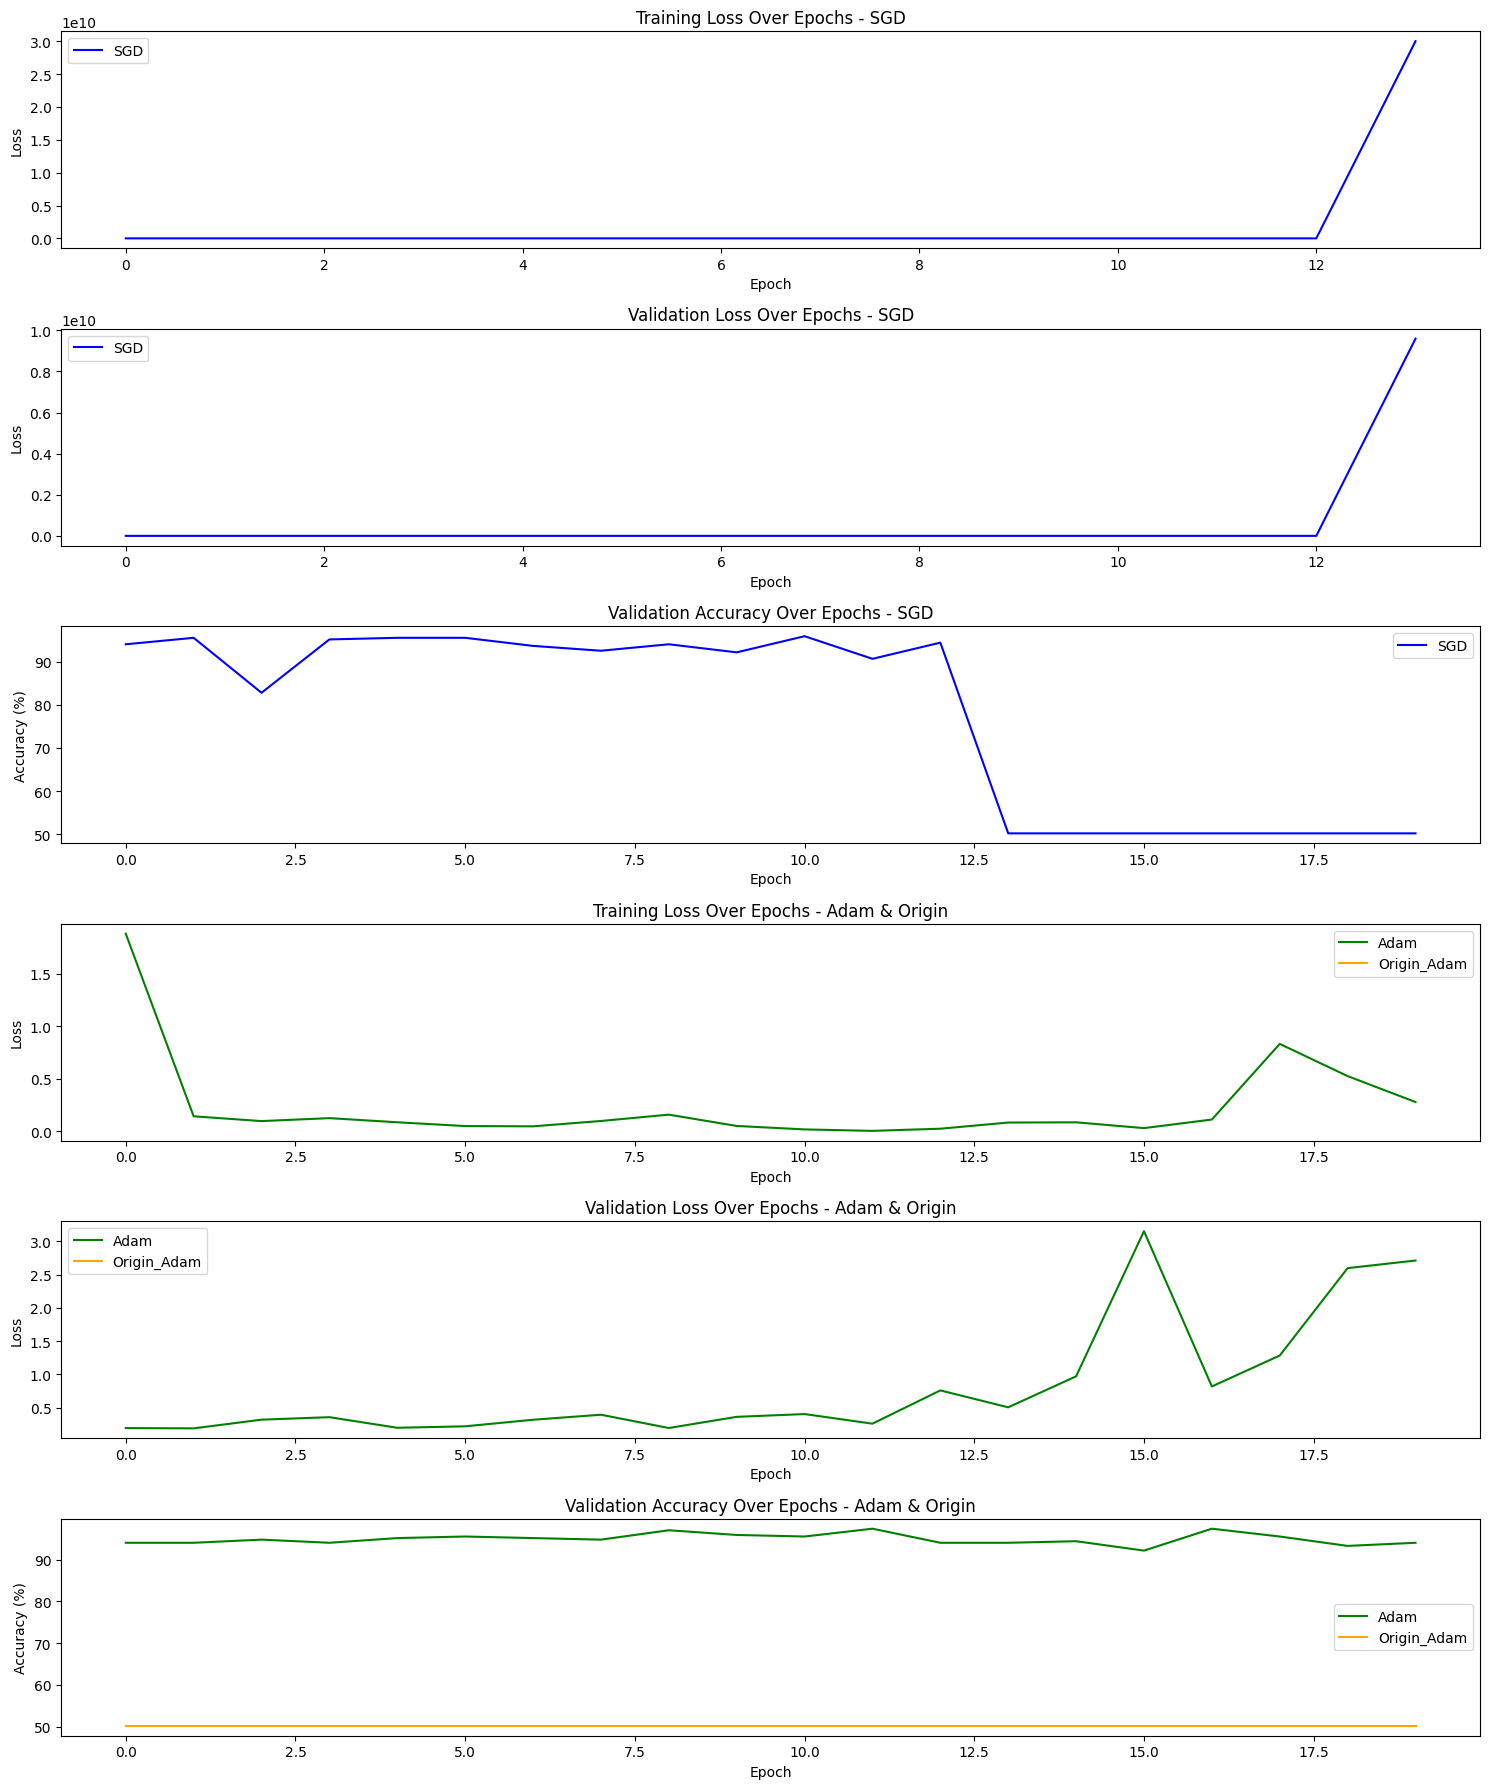

In [26]:
# 학습 손실과 검증 정확도 그래프 그리기 (SGD와 Adam/Origin 분리)
plt.figure(figsize=(15, 18))

# ========== SGD 그래프 ==========
# SGD 학습 손실
plt.subplot(6, 1, 1)
plt.plot(train_losses_SGD, label='SGD', color='blue')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs - SGD')
plt.legend()

# SGD 검증 손실
plt.subplot(6, 1, 2)
plt.plot(val_losses_SGD, label='SGD', color='blue')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Validation Loss Over Epochs - SGD')
plt.legend()

# SGD 검증 정확도
plt.subplot(6, 1, 3)
plt.plot(val_accuracies_SGD, label='SGD', color='blue')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Validation Accuracy Over Epochs - SGD')
plt.legend()

# ========== Adam/Origin 그래프 ==========
# Adam/Origin 학습 손실
plt.subplot(6, 1, 4)
plt.plot(train_losses_Adam, label='Adam', color='green')
plt.plot(origin_model_train_losses_Adam, label='Origin_Adam', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs - Adam & Origin')
plt.legend()

# Adam/Origin 검증 손실
plt.subplot(6, 1, 5)
plt.plot(val_losses_Adam, label='Adam', color='green')
plt.plot(origin_model_val_losses_Adam, label='Origin_Adam', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Validation Loss Over Epochs - Adam & Origin')
plt.legend()

# Adam/Origin 검증 정확도
plt.subplot(6, 1, 6)
plt.plot(val_accuracies_Adam, label='Adam', color='green')
plt.plot(origin_model_val_accuracies_Adam, label='Origin_Adam', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Validation Accuracy Over Epochs - Adam & Origin')
plt.legend()

plt.tight_layout()
plt.show()

## 🧪 테스트 데이터 예측 결과

학습된 모델(Adam 전이학습)로 테스트 데이터 예측 수행

**테스트 구성**:
- 각 클래스(normal, santa)당 5장씩 총 10장
- Validation transform 적용 (증강 없이)
- 2행 5열 그리드로 시각화

**결과 확인**:
- True label vs Predicted label 비교
- 모델의 실제 분류 성능 시각적 검증

➡️ 학습된 모델의 일반화 능력 확인! ✅

In [28]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

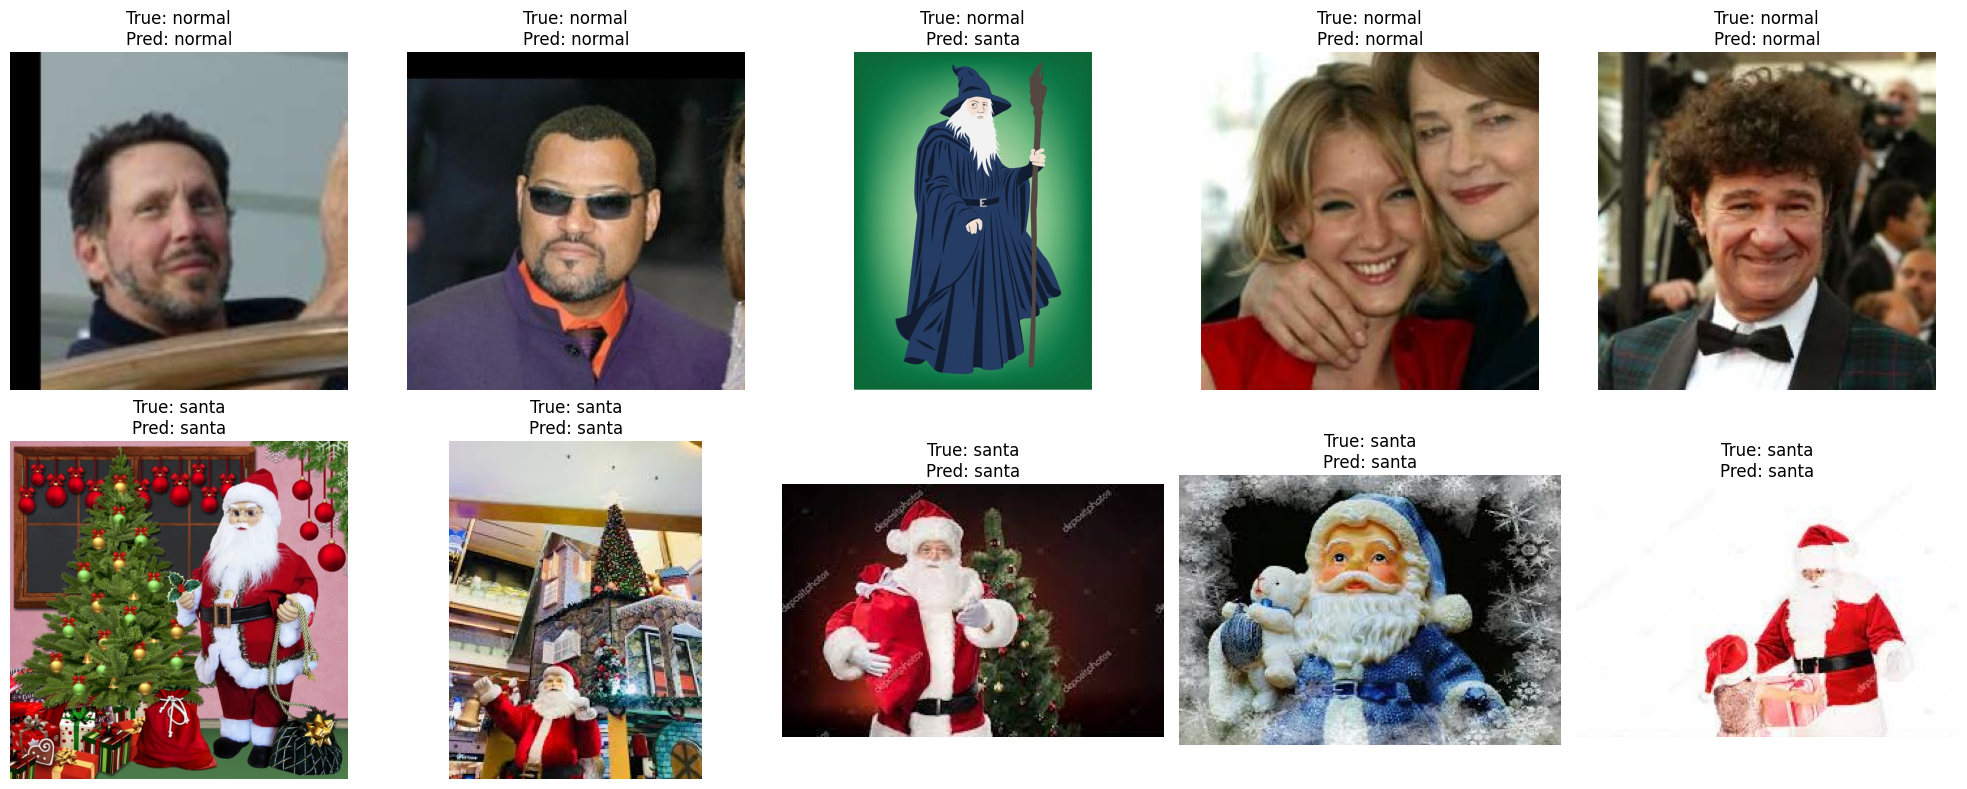

In [29]:
def load_and_transform_image(image_path, transform):
    image = Image.open(image_path).convert('RGB')
    return transform(image).unsqueeze(0)

# 클래스 폴더 경로 설정
class_folders = {
    'normal': '/content/drive/MyDrive/개인_팀_프로젝트/VGG19_모델_구현, 전이학습/data/santa/test/normal',
    'santa': '/content/drive/MyDrive/개인_팀_프로젝트/VGG19_모델_구현, 전이학습/data/santa/test/santa'
}

plt.figure(figsize=(20, 8))
counter = 1

for class_name, folder_path in class_folders.items():
    # 폴더 내 이미지 경로 가져오기
    image_paths = glob.glob(os.path.join(folder_path, '*'))
    selected_paths = image_paths[:5]  # 각 클래스당 5장

    for image_path in selected_paths:
        # 이미지 로드 및 전처리
        image = load_and_transform_image(image_path, transform_val)
        image = image.to(device)

        # 모델 예측
        model.eval()
        with torch.no_grad():
            outputs = model(image)
            _, predicted = torch.max(outputs, 1)

        # 예측 결과 (0: normal, 1: santa)
        prediction = 'normal' if predicted.item() == 0 else 'santa'

        # 시각화
        plt.subplot(2, 5, counter)
        plt.imshow(Image.open(image_path))
        plt.title(f'True: {class_name}\nPred: {prediction}')
        plt.axis('off')
        counter += 1

plt.tight_layout()
plt.show()